LitSearch Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import List, Any, Tuple
from datasets import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from enum import Enum
import openai
import pickle
from InstructorEmbedding import INSTRUCTOR
from gritlm import GritLM
import sentence_transformers
from datasets import load_dataset

In [3]:
query_data = load_dataset("princeton-nlp/LitSearch", "query", split="full")
corpus_clean_data = load_dataset("princeton-nlp/LitSearch", "corpus_clean", split="full")
corpus_s2orc_data = load_dataset("princeton-nlp/LitSearch", "corpus_s2orc", split="full")

In [4]:
query_df = query_data.to_pandas()
corpus_clean_df = corpus_clean_data.to_pandas()
corpus_s2orc_df = corpus_s2orc_data.to_pandas()

In [5]:
query_df.head()

,query_set,query,specificity,quality,corpusids
0,inline_acl,Are there any research papers on methods to co...,0,2,[202719327]
1,inline_acl,Are there any resources available for translat...,1,2,[227231792]
2,inline_acl,Are there any studies that explore post-hoc te...,0,2,"[226254579, 204976362]"
3,inline_acl,Are there any tools or studies that have focus...,1,2,"[10961392, 12160022]"
4,inline_acl,Are there papers that propose contextualized c...,1,2,[233296182]


In [14]:
print(query_df.loc[0, "query"])

Are there any research papers on methods to compress large-scale language models using task-agnostic knowledge distillation techniques?


In [7]:
corpus_clean_df.head()

,corpusid,title,abstract,citations,full_paper
0,252715594,PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM...,"We present Phenaki, a model capable of realist...","[6628106, 174802916, 238582653]",PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM...
1,13002849,MODE REGULARIZED GENERATIVE ADVERSARIAL NETWORKS,Although Generative Adversarial Networks achie...,[],MODE REGULARIZED GENERATIVE ADVERSARIAL NETWOR...
2,239998253,What Do We Mean by Generalization in Federated...,Federated learning data is drawn from a distri...,"[235613568, 231924480, 211678094, 195798643, 4...",What Do We Mean by Generalization in Federated...
3,62841605,SPREADING VECTORS FOR SIMILARITY SEARCH,Discretizing multi-dimensional data distributi...,[],SPREADING VECTORS FOR SIMILARITY SEARCH\n\n\nA...
4,253237531,MACHINE UNLEARNING OF FEDERATED CLUSTERS,Federated clustering (FC) is an unsupervised l...,[],MACHINE UNLEARNING OF FEDERATED CLUSTERS\n\n\n...


In [9]:
corpus_s2orc_df.head()

,corpusid,externalids,content,year
0,252715594,"{'acl': None, 'arxiv': '2210.02399', 'dblp': '...","{'annotations': {'abstract': '[{""end"":2761,""st...",2023.0
1,13002849,"{'acl': None, 'arxiv': '1612.02136', 'dblp': '...","{'annotations': {'abstract': '[{""end"":1726,""st...",2017.0
2,239998253,"{'acl': None, 'arxiv': None, 'dblp': 'conf/icl...","{'annotations': {'abstract': '[{""end"":1082,""st...",2022.0
3,62841605,"{'acl': None, 'arxiv': '1806.03198', 'dblp': '...","{'annotations': {'abstract': '[{""end"":1503,""st...",2019.0
4,253237531,"{'acl': None, 'arxiv': '2210.16424', 'dblp': '...","{'annotations': {'abstract': '[{""end"":2886,""st...",2023.0


Q1: To find the number of queries with more than one corpusid

In [10]:
def count_corpusids(df, column_name="corpusids"):
    return df[column_name].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x))

query_df["corpusid_count"] = count_corpusids(query_df)

In [11]:
query_df.head()

,query_set,query,specificity,quality,corpusids,corpusid_count
0,inline_acl,Are there any research papers on methods to co...,0,2,[202719327],1
1,inline_acl,Are there any resources available for translat...,1,2,[227231792],1
2,inline_acl,Are there any studies that explore post-hoc te...,0,2,"[226254579, 204976362]",2
3,inline_acl,Are there any tools or studies that have focus...,1,2,"[10961392, 12160022]",2
4,inline_acl,Are there papers that propose contextualized c...,1,2,[233296182],1


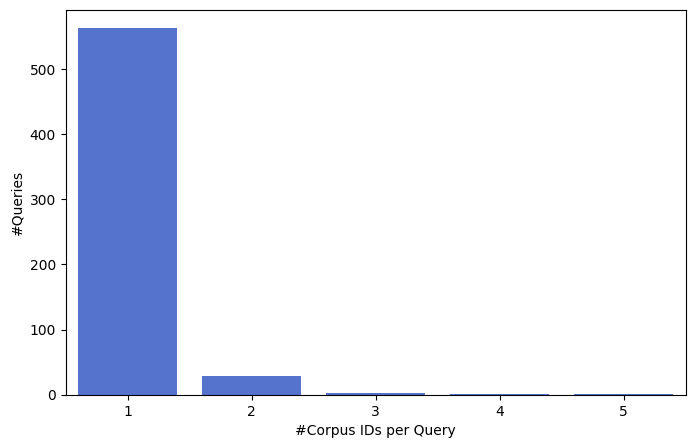

In [12]:
import seaborn as sns

corpusid_distribution = query_df["corpusid_count"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=corpusid_distribution.index, y=corpusid_distribution.values, color="royalblue")
plt.xlabel("#Corpus IDs per Query")
plt.ylabel("#Queries")
plt.xticks(rotation=0)

plt.show()

Q2: Is the data already preprocessed?

In [13]:
print(corpus_clean_df.loc[0, "full_paper"])

PHENAKI: VARIABLE LENGTH VIDEO GENERATION FROM OPEN DOMAIN TEXTUAL DESCRIPTIONS


Ruben Villegas 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Mohammad Babaeizadeh 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Pieter-Jan Kindermans 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Hernan Moraldo hmoraldo@google.com 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Han Zhang zhanghan@google.com 
University of Michigan
University College London


Google Brain 
University of Michigan
University College London


Mohammad Taghi 
University of Michigan
University College London


Saffar Google Brain 
University of Michigan
University College London


Santiago Castro sacastro@umich.edu 
University of Michigan
University C

In [15]:
corpus_clean_df[corpus_clean_df["corpusid"].isin([6628106, 174802916, 238582653])]


,corpusid,title,abstract,citations,full_paper
3460,174802916,Published as a conference paper at ICLR 2020 S...,"Due to the statistical complexity of video, th...","[54458552, 205514, 52892477, 8495258]",Published as a conference paper at ICLR 2020 S...
4009,238582653,VECTOR-QUANTIZED IMAGE MODELING WITH IM- PROVE...,Pretraining language models with next-token pr...,"[227127234, 52967399, 3568073, 84591, 4009713,...",VECTOR-QUANTIZED IMAGE MODELING WITH IM- PROVE...
4156,6628106,ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION,"We introduce Adam, an algorithm for first-orde...",[1428702],ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION\n\n...


In [16]:
query_counts = query_df.groupby('query_set').size().reset_index(name='count')
print(query_counts)

       query_set  count
0     inline_acl     98
1  inline_nonacl    253
2     manual_acl    155
3    manual_iclr     91


In [17]:
corpus_clean_df.astype(str).nunique()

corpusid      64183
title         56717
abstract      55909
citations     44680
full_paper    63725
dtype: int64

ALCE

In [21]:
%cd ALCE

/data/horse/ws/uskh580e-llm_citation_ws/ALCE


/data/horse/ws/uskh580e-llm_citation_ws/myenv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [22]:
!ls

assets		  eval.py     post_hoc_cite.py	run.py
configs		  human_eval  prompts		searcher.py
data		  LICENSE     README.md		tools
download_data.sh  paper       retrieval.py	utils.py


In [23]:
!bash download_data.sh

--2025-02-07 20:30:31--  https://huggingface.co/datasets/princeton-nlp/ALCE-data/resolve/main/ALCE-data.tar
Resolving huggingface.co (huggingface.co)... 3.160.150.7, 3.160.150.119, 3.160.150.2, ...
Connecting to huggingface.co (huggingface.co)|3.160.150.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/56/20/5620fb830225268cf35bc951e315c64ab64bc534c5c9ea4f4fcf278da5389466/eda837bf659a91b3648dc6e7ab6b17197664d93593857e8fdf3800b6aa6a98f0?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27ALCE-data.tar%3B+filename%3D%22ALCE-data.tar%22%3B&response-content-type=application%2Fx-tar&Expires=1738960232&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczODk2MDIzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy81Ni8yMC81NjIwZmI4MzAyMjUyNjhjZjM1YmM5NTFlMzE1YzY0YWI2NGJjNTM0YzVjOWVhNGY0ZmNmMjc4ZGE1Mzg5NDY2L2VkYTgzN2JmNjU5YTkxYjM2NDhkYzZlN2FiNmIxNzE5NzY2NGQ5MzU5Mzg1N2U4ZmRmMzgwMGI2

In [25]:
!ls -l data/

total 8
drwxr-xr-x. 3 uskh580e p_scads_llm_secrets 4096 Feb  7 20:28 ALCE-data
drwxr-xr-x. 2 uskh580e p_scads_llm_secrets 4096 Jan 31 23:38 asqa


In [26]:
!ls -l data/ALCE-data

total 440744
-rw-r--r--. 1 uskh580e p_scads_llm_secrets 83625528 May 23  2023 asqa_eval_dpr_top100.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets 84762794 May 23  2023 asqa_eval_gtr_top100.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets 10350811 May 23  2023 asqa_eval_gtr_top100_reranked_oracle.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets 83469180 May 23  2023 eli5_eval_bm25_top100.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets  7631357 May 23  2023 eli5_eval_bm25_top100_reranked_oracle.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets 85769271 May 23  2023 qampari_eval_dpr_top100.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets 87241220 May 23  2023 qampari_eval_gtr_top100.json
-rw-r--r--. 1 uskh580e p_scads_llm_secrets  8434999 May 23  2023 qampari_eval_gtr_top100_reranked_oracle.json


In [28]:
data_dir = "data/ALCE-data"

# List all JSON files in the directory
json_files = [f for f in os.listdir(data_dir) if f.endswith(".json")]

# Dictionary to store DataFrames
df_dict = {}

# Loop through each JSON file and convert to DataFrame
for file in json_files:
    file_path = os.path.join(data_dir, file)
    
    # Load JSON file
    with open(file_path, "r") as f:
        data = json.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Store DataFrame in a dictionary with the filename (without .json)
    df_dict[file.replace(".json", "")] = df

    # Display the first few rows
    print(f"\nDataFrame for {file}:")
    display(df.head())




DataFrame for eli5_eval_bm25_top100_reranked_oracle.json:


,question,question_ctx,answer,claims,docs
0,"How are firms like snapchat, uber etc valued s...",[removed],Yes. Did you watch The Social Network? They we...,[Firms like Snapchat and Uber need to establis...,[{'title': 'Is Snapchat really worth $19 billi...
1,Why is it bad to eat cookie dough for risk of ...,,"Any edible ""cookie dough"" products are made wi...",[Cookie Dough Bites are safe to eat since they...,[{'title': 'It's Probably OK to Eat Raw Cookie...
2,how does so much of our trash end up in the oc...,I read that something like 80% of plastic ends...,Because water flows downhill and very often en...,"[When it rains, trash is washed downhill and i...","[{'title': 'ENVIRONMENTAL THREATS', 'text': 't..."
3,please explain American equivalents for Britis...,I have always loved British comedy shows. Pyth...,**Education:**\n\nProgression is measured in Y...,"[In the UK, primary school is for Key Stages 1...","[{'title': 'Integration hub | Education', 'tex..."
4,"What are quantifiers, and the difference betwe...",,Okay so there are two types of common quantifi...,[Quantifiers are symbols that are used to repr...,[{'title': 'The cognitive functions of languag...



DataFrame for qampari_eval_gtr_top100.json:


,id,question,answers,docs,answer
0,799__wikidata_simple__dev,What manga was drawn by Ryoichi Ikegami?,"[[Heat], [Mai, the Psychic Girl], [Wounded Man...","[{'id': '8377518', 'title': 'Ryu Fujisaki', 't...","Heat, Mai, the Psychic Girl, Wounded Man, Sanc..."
1,136__wikidata_intersection__dev,Harmony Korine was both screenwriter and direc...,"[[Spring Breakers], [Trash Humpers], [Julien D...","[{'id': '3518783', 'title': 'Harmony Korine', ...","Spring Breakers, Trash Humpers, Julien Donkey-..."
2,248__wikidata_comp__dev,Where did administrators of the UN Development...,"[[University of Auckland], [Yale Law School], ...","[{'id': '5654454', 'title': 'United Nations In...","University of Auckland, Yale Law School, Marlb..."
3,366__wikidata_comp__dev,Who directed a film that had P. Balachandran a...,"[[Kamal], [P. Balachandran], [T. K. Rajeev Kum...","[{'id': '12727772', 'title': 'Server Sundaram'...","Kamal, P. Balachandran, T. K. Rajeev Kumar, V...."
4,663__wikidata_simple__dev,The Russian Empire has what ships registered t...,"[[Russian gunboat Sivuch], [Russian cruiser Ad...","[{'id': '13872170', 'title': 'Russian Maritime...","Russian gunboat Sivuch, Russian cruiser Admira..."



DataFrame for asqa_eval_gtr_top100.json:


,qa_pairs,wikipages,annotations,sample_id,question,docs,answer
0,"[{'context': 'No context provided', 'question'...",[{'title': 'International Federation of Footba...,"[{'knowledge': [], 'long_answer': 'Ali Dael ha...",-7013890438520559398,Who has the highest goals in world football?,"[{'id': '6669150', 'title': 'Argentina–Brazil ...",The players with the highest all-time goals an...
1,[{'context': 'Sounds of Silence is the second ...,"[{'title': 'The Sound of Silence', 'url': 'htt...",[{'knowledge': [{'content': 'Wednesday Morning...,7089015503030534342,Who is the original artist of sound of silence?,"[{'id': '2627084', 'title': 'The Sound of Sile...","There are several songs with the title ""Sound ..."
2,"[{'context': 'On January 9, 2007, Steve Jobs a...","[{'title': 'iPhone (1st generation)', 'url': '...",[{'knowledge': [{'content': 'The iPhone was re...,8793099883447006698,When was the first apple i phone made?,"[{'id': '14664751', 'title': 'IPhone (1st gene...","There were several Apple iPhones, including th..."
3,[{'context': 'Richard Fish appeared as Bill br...,"[{'title': 'List of Harry Potter characters', ...",[{'knowledge': [{'content': 'Dozens of actors ...,-881464876144297194,Who played the weasley brothers in harry potter?,"[{'id': '5621126', 'title': 'James and Oliver ...",The Weasely family is a family of wizards incl...
4,"[{'context': 'No context provided', 'question'...","[{'title': 'List of Virginia state parks', 'ur...",[{'knowledge': [{'content': 'Virginia opened i...,1650309494326541834,How many state parks are there in virginia?,"[{'id': '444081', 'title': 'Virginia', 'text':...",Virginia opened its entire state park system o...



DataFrame for qampari_eval_dpr_top100.json:


,id,question,answers,docs,answer
0,799__wikidata_simple__dev,What manga was drawn by Ryoichi Ikegami?,"[[Heat], [Mai, the Psychic Girl], [Wounded Man...","[{'id': 'wiki:8377518', 'title': 'Ryu Fujisaki...","Heat, Mai, the Psychic Girl, Wounded Man, Sanc..."
1,136__wikidata_intersection__dev,Harmony Korine was both screenwriter and direc...,"[[Spring Breakers], [Trash Humpers], [Julien D...","[{'id': 'wiki:3518795', 'title': 'Harmony Kori...","Spring Breakers, Trash Humpers, Julien Donkey-..."
2,248__wikidata_comp__dev,Where did administrators of the UN Development...,"[[University of Auckland], [Yale Law School], ...","[{'id': 'wiki:5655643', 'title': 'United Natio...","University of Auckland, Yale Law School, Marlb..."
3,366__wikidata_comp__dev,Who directed a film that had P. Balachandran a...,"[[Kamal], [P. Balachandran], [T. K. Rajeev Kum...","[{'id': 'wiki:16710085', 'title': 'P. Balachan...","Kamal, P. Balachandran, T. K. Rajeev Kumar, V...."
4,663__wikidata_simple__dev,The Russian Empire has what ships registered t...,"[[Russian gunboat Sivuch], [Russian cruiser Ad...","[{'id': 'wiki:2353570', 'title': 'Russian Navy...","Russian gunboat Sivuch, Russian cruiser Admira..."



DataFrame for asqa_eval_gtr_top100_reranked_oracle.json:


,qa_pairs,wikipages,annotations,sample_id,question,docs,answer
0,"[{'context': 'No context provided', 'question'...",[{'title': 'International Federation of Footba...,"[{'knowledge': [], 'long_answer': 'Ali Dael ha...",-7013890438520559398,Who has the highest goals in world football?,"[{'id': '6669150', 'title': 'Argentina–Brazil ...",The players with the highest all-time goals an...
1,[{'context': 'Sounds of Silence is the second ...,"[{'title': 'The Sound of Silence', 'url': 'htt...",[{'knowledge': [{'content': 'Wednesday Morning...,7089015503030534342,Who is the original artist of sound of silence?,"[{'id': '2627084', 'title': 'The Sound of Sile...","There are several songs with the title ""Sound ..."
2,"[{'context': 'On January 9, 2007, Steve Jobs a...","[{'title': 'iPhone (1st generation)', 'url': '...",[{'knowledge': [{'content': 'The iPhone was re...,8793099883447006698,When was the first apple i phone made?,"[{'id': '14664751', 'title': 'IPhone (1st gene...","There were several Apple iPhones, including th..."
3,[{'context': 'Richard Fish appeared as Bill br...,"[{'title': 'List of Harry Potter characters', ...",[{'knowledge': [{'content': 'Dozens of actors ...,-881464876144297194,Who played the weasley brothers in harry potter?,"[{'id': '1884113', 'title': 'Order of the Phoe...",The Weasely family is a family of wizards incl...
4,"[{'context': 'No context provided', 'question'...","[{'title': 'List of Virginia state parks', 'ur...",[{'knowledge': [{'content': 'Virginia opened i...,1650309494326541834,How many state parks are there in virginia?,"[{'id': '12057784', 'title': 'Virginia Departm...",Virginia opened its entire state park system o...



DataFrame for eli5_eval_bm25_top100.json:


,question,question_ctx,answer,claims,docs
0,"How are firms like snapchat, uber etc valued s...",[removed],Yes. Did you watch The Social Network? They we...,[Firms like Snapchat and Uber need to establis...,[{'title': 'Is Snapchat really worth $19 billi...
1,Why is it bad to eat cookie dough for risk of ...,,"Any edible ""cookie dough"" products are made wi...",[Cookie Dough Bites are safe to eat since they...,[{'title': 'How to Treat and Prevent Food Pois...
2,how does so much of our trash end up in the oc...,I read that something like 80% of plastic ends...,Because water flows downhill and very often en...,"[When it rains, trash is washed downhill and i...","[{'title': 'Teachers', 'text': 'The programs a..."
3,please explain American equivalents for Britis...,I have always loved British comedy shows. Pyth...,**Education:**\n\nProgression is measured in Y...,"[In the UK, primary school is for Key Stages 1...","[{'title': 'Integration hub | Education', 'tex..."
4,"What are quantifiers, and the difference betwe...",,Okay so there are two types of common quantifi...,[Quantifiers are symbols that are used to repr...,[{'title': 'The completeness and compactness t...



DataFrame for qampari_eval_gtr_top100_reranked_oracle.json:


,id,question,answers,docs,answer
0,799__wikidata_simple__dev,What manga was drawn by Ryoichi Ikegami?,"[[Heat], [Mai, the Psychic Girl], [Wounded Man...","[{'id': '7329293', 'title': 'History of manga'...","Heat, Mai, the Psychic Girl, Wounded Man, Sanc..."
1,136__wikidata_intersection__dev,Harmony Korine was both screenwriter and direc...,"[[Spring Breakers], [Trash Humpers], [Julien D...","[{'id': '3518783', 'title': 'Harmony Korine', ...","Spring Breakers, Trash Humpers, Julien Donkey-..."
2,248__wikidata_comp__dev,Where did administrators of the UN Development...,"[[University of Auckland], [Yale Law School], ...","[{'id': '5654454', 'title': 'United Nations In...","University of Auckland, Yale Law School, Marlb..."
3,366__wikidata_comp__dev,Who directed a film that had P. Balachandran a...,"[[Kamal], [P. Balachandran], [T. K. Rajeev Kum...","[{'id': '15097804', 'title': 'Ivan Megharoopan...","Kamal, P. Balachandran, T. K. Rajeev Kumar, V...."
4,663__wikidata_simple__dev,The Russian Empire has what ships registered t...,"[[Russian gunboat Sivuch], [Russian cruiser Ad...","[{'id': '16901181', 'title': 'Russian ship of ...","Russian gunboat Sivuch, Russian cruiser Admira..."



DataFrame for asqa_eval_dpr_top100.json:


,qa_pairs,wikipages,annotations,sample_id,answer,question,docs
0,"[{'context': 'No context provided', 'question'...",[{'title': 'International Federation of Footba...,"[{'knowledge': [], 'long_answer': 'Ali Dael ha...",-7013890438520559398,The players with the highest all-time goals an...,Who has the highest goals in world football?,"[{'id': 'wiki:3262915', 'title': 'FIFA World R..."
1,[{'context': 'Sounds of Silence is the second ...,"[{'title': 'The Sound of Silence', 'url': 'htt...",[{'knowledge': [{'content': 'Wednesday Morning...,7089015503030534342,"There are several songs with the title ""Sound ...",Who is the original artist of sound of silence?,"[{'id': 'wiki:2627084', 'title': 'The Sound of..."
2,"[{'context': 'On January 9, 2007, Steve Jobs a...","[{'title': 'iPhone (1st generation)', 'url': '...",[{'knowledge': [{'content': 'The iPhone was re...,8793099883447006698,"There were several Apple iPhones, including th...",When was the first apple i phone made?,"[{'id': 'wiki:5974', 'title': 'Apple I', 'text..."
3,[{'context': 'Richard Fish appeared as Bill br...,"[{'title': 'List of Harry Potter characters', ...",[{'knowledge': [{'content': 'Dozens of actors ...,-881464876144297194,The Weasely family is a family of wizards incl...,Who played the weasley brothers in harry potter?,"[{'id': 'wiki:7276354', 'title': 'Oh No, It's ..."
4,"[{'context': 'No context provided', 'question'...","[{'title': 'List of Virginia state parks', 'ur...",[{'knowledge': [{'content': 'Virginia opened i...,1650309494326541834,Virginia opened its entire state park system o...,How many state parks are there in virginia?,"[{'id': 'wiki:444081', 'title': 'Virginia', 't..."


QASPER

In [2]:
qasper_dataset = load_dataset("allenai/qasper")

Generating train split:   0%|          | 0/888 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/281 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/416 [00:00<?, ? examples/s]

In [4]:
print(qasper_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'],
        num_rows: 888
    })
    validation: Dataset({
        features: ['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'],
        num_rows: 281
    })
    test: Dataset({
        features: ['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'],
        num_rows: 416
    })
})


In [5]:
train_data = qasper_dataset["train"]
validation_data = qasper_dataset["validation"]
test_data = qasper_dataset["test"]


In [6]:
train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

In [7]:
train_df.sample(1).to_dict()

{'id': {30: '2003.08553'},
 'title': {30: 'QnAMaker: Data to Bot in 2 Minutes'},
 'abstract': {30: 'Having a bot for seamless conversations is a much-desired feature that products and services today seek for their websites and mobile apps. These bots help reduce traffic received by human support significantly by handling frequent and directly answerable known questions. Many such services have huge reference documents such as FAQ pages, which makes it hard for users to browse through this data. A conversation layer over such raw data can lower traffic to human support by a great margin. We demonstrate QnAMaker, a service that creates a conversational layer over semi-structured data such as FAQ pages, product manuals, and support documents. QnAMaker is the popular choice for Extraction and Question-Answering as a service and is used by over 15,000 bots in production. It is also used by search interfaces and not just bots.'},
 'full_text': {30: {'section_name': ['Introduction',
    'Syst

In [9]:
test_df.head()

,id,title,abstract,full_text,qas,figures_and_tables
0,1911.10742,End-to-End Trainable Non-Collaborative Dialog ...,End-to-end task-oriented dialog models have ac...,"{'section_name': ['Introduction', 'Related Wor...",{'question': ['How big is the ANTISCAM dataset...,{'caption': ['Table 1: Hierarchical intent ann...
1,1904.09131,OpenTapioca: Lightweight Entity Linking for Wi...,We propose a simple Named Entity Linking syste...,"{'section_name': ['Introduction', 'Particulari...",{'question': ['What is the accuracy of this mo...,{'caption': ['Figure 1: Example of an annotate...
2,1611.06322,Spotting Rumors via Novelty Detection,Rumour detection is hard because the most accu...,"{'section_name': ['Introduction', 'Related Wor...",{'question': ['What previous methods do they c...,{'caption': ['Table 1: Excerpt of topics with ...
3,1604.02038,Sentence Level Recurrent Topic Model: Letting ...,We propose Sentence Level Recurrent Topic Mode...,"{'section_name': ['Introduction', 'Related Wor...",{'question': ['What baselines did they compare...,{'caption': ['Figure 1: The illustration of th...
4,1911.04474,TENER: Adapting Transformer Encoder for Named ...,The Bidirectional long short-term memory netwo...,"{'section_name': ['Introduction', 'Related Wor...",{'question': ['Which NER dataset do they use?'...,{'caption': ['Figure 1: An example for NER. Th...


In [10]:
print(train_df.loc[0, "full_text"])

{'section_name': ['Introduction', 'Related Work', 'Proposed Method', 'Proposed Method ::: Polarity Function', 'Proposed Method ::: Discourse Relation-Based Event Pairs', 'Proposed Method ::: Discourse Relation-Based Event Pairs ::: AL (Automatically Labeled Pairs)', 'Proposed Method ::: Discourse Relation-Based Event Pairs ::: CA (Cause Pairs)', 'Proposed Method ::: Discourse Relation-Based Event Pairs ::: CO (Concession Pairs)', 'Proposed Method ::: Loss Functions', 'Experiments', 'Experiments ::: Dataset', 'Experiments ::: Dataset ::: AL, CA, and CO', 'Experiments ::: Dataset ::: ACP (ACP Corpus)', 'Experiments ::: Model Configurations', 'Experiments ::: Results and Discussion', 'Conclusion', 'Acknowledgments', 'Appendices ::: Seed Lexicon ::: Positive Words', 'Appendices ::: Seed Lexicon ::: Negative Words', 'Appendices ::: Settings of Encoder ::: BiGRU', 'Appendices ::: Settings of Encoder ::: BERT'], 'paragraphs': [["Affective events BIBREF0 are events that typically affect people

In [11]:
print(train_df.loc[0, "figures_and_tables"])

{'caption': ['Figure 1: An overview of our method. We focus on pairs of events, the former events and the latter events, which are connected with a discourse relation, CAUSE or CONCESSION. Dropped pronouns are indicated by brackets in English translations. We divide the event pairs into three types: AL, CA, and CO. In AL, the polarity of a latter event is automatically identified as either positive or negative, according to the seed lexicon (the positive word is colored red and the negative word blue). We propagate the latter event’s polarity to the former event. The same polarity as the latter event is used for the discourse relation CAUSE, and the reversed polarity for CONCESSION. In CA and CO, the latter event’s polarity is not known. Depending on the discourse relation, we encourage the two events’ polarities to be the same (CA) or reversed (CO). Details are given in Section 3.2.', 'Table 1: Statistics of the AL, CA, and CO datasets.', 'Table 2: Details of the ACP dataset.', 'Table

In [12]:
print(train_df.loc[0, "qas"])

{'question': ['What is the seed lexicon?', 'What are the results?', 'How are relations used to propagate polarity?', 'How big is the Japanese data?', 'What are labels available in dataset for supervision?', 'How big are improvements of supervszed learning results trained on smalled labeled data enhanced with proposed approach copared to basic approach?', 'How does their model learn using mostly raw data?', 'How big is seed lexicon used for training?', 'How large is raw corpus used for training?'], 'question_id': ['753990d0b621d390ed58f20c4d9e4f065f0dc672', '9d578ddccc27dd849244d632dd0f6bf27348ad81', '02e4bf719b1a504e385c35c6186742e720bcb281', '44c4bd6decc86f1091b5fc0728873d9324cdde4e', '86abeff85f3db79cf87a8c993e5e5aa61226dc98', 'c029deb7f99756d2669abad0a349d917428e9c12', '39f8db10d949c6b477fa4b51e7c184016505884f', 'd0bc782961567dc1dd7e074b621a6d6be44bb5b4', 'a592498ba2fac994cd6fad7372836f0adb37e22a'], 'nlp_background': ['two', 'two', 'two', 'two', 'zero', 'zero', 'zero', 'zero', 'zero